## Sentiment Analysis on Trustpilot Data (Mexico all companies)

In [ ]:
!pip install nltk matplotlib seaborn wordcloud langdetect googletrans==4.0.0-rc1 vaderSentiment

In [2]:
import pandas as pd
import re

In [4]:
movistar = pd.read_csv("./reviews/MX/trustpilot_movistar_reviews.csv")
movistar["operator"] = "Movistar"
movistar["country"] = "Mexico"

telcel = pd.read_csv("./reviews/MX/trustpilot_telcel_reviews.csv")
telcel["operator"] = "TelCell"
telcel["country"] = "Mexico"

ais = pd.read_csv("./reviews/THA/trustpilot_ais_reviews.csv")
ais["operator"] = "AIS"
ais["country"] = "Thailand"

dtac = pd.read_csv("./reviews/THA/trustpilot_dtac_reviews.csv")
dtac["operator"] = "DTAC"
dtac["country"] = "Thailand"

truemoveh = pd.read_csv("./reviews/THA/trustpilot_truemoveh_reviews.csv")
truemoveh["operator"] = "TrueMove H"
truemoveh["country"] = "Thailand"

cellc = pd.read_csv("./reviews/SA/hellopeter_cellc_reviews.csv")
cellc["operator"] = "Cell C"
cellc["country"] = "South Africa"

mtn = pd.read_csv("./reviews/SA/hellopeter_mtn_reviews.csv")
mtn["operator"] = "MTN"
mtn["country"] = "South Africa"

vodacom = pd.read_csv("./reviews/SA/hellopeter_vodacom_reviews_scroll.csv")
vodacom["operator"] = "Vodacom"
vodacom["country"] = "South Africa"

sa_reddit = pd.read_csv("./reviews/SA/reddit_comments.csv")
sa_reddit["operator"] = "Reddit"
sa_reddit["country"] = "South Africa"

In [6]:
df = pd.concat([movistar, telcel, ais, dtac, truemoveh, cellc, mtn, vodacom, sa_reddit], ignore_index=True)

In [7]:
df.head(2)

,username,review,operator,country,date,author,comment
0,PJ,"Slow, specially in Sumer, to the point of bein...",Movistar,Mexico,NaN,NaN,NaN
1,PJ Jones,Shocking service. Out of contract and monthly ...,Movistar,Mexico,NaN,NaN,NaN


In [8]:
df = df.drop(columns=[col for col in ["date", "author", "comment"] if col in df.columns])

In [10]:
df.head(2)

,username,review,operator,country
0,PJ,"Slow, specially in Sumer, to the point of bein...",Movistar,Mexico
1,PJ Jones,Shocking service. Out of contract and monthly ...,Movistar,Mexico


In [12]:
df.to_csv("./reviews/all_reviews.csv", index=False)

In [13]:
# Clean up any missing reviews
df = df.dropna(subset=["review"])

In [14]:
# lowercase, remove non-alphabetic characters
df["clean_review"] = df["review"].str.lower().apply(lambda x: re.sub(r"[^a-z\s]", "", x))

In [15]:
from langdetect import detect
from googletrans import Translator

In [27]:
df.dropna(subset=["clean_review"], inplace=True)

In [16]:
translator = Translator()

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["language"] = df["clean_review"].apply(detect_language)

In [17]:
# Translate only non-English
def translate_if_needed(row):
    if row["language"] != "en":
        try:
            return translator.translate(row["clean_review"], dest='en').text
        except:
            return row["clean_review"]
    else:
        return row["clean_review"]

df["translated_review"] = df.apply(translate_if_needed, axis=1)

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [19]:
nltk.download("vader_lexicon")

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\deyna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
# Run sentiment analysis
df["sentiment"] = df["translated_review"].apply(lambda x: sid.polarity_scores(x)["compound"])

# Label sentiment for easier interpretation
def label_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment"].apply(label_sentiment)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

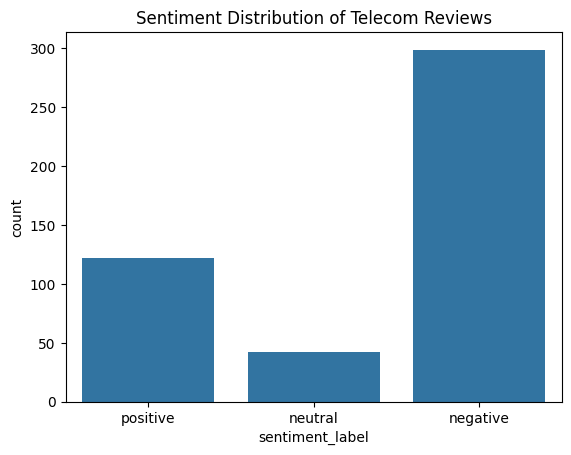

In [22]:
sns.countplot(data=df, x="sentiment_label", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution of Telecom Reviews")
plt.show()

In [23]:
from wordcloud import WordCloud

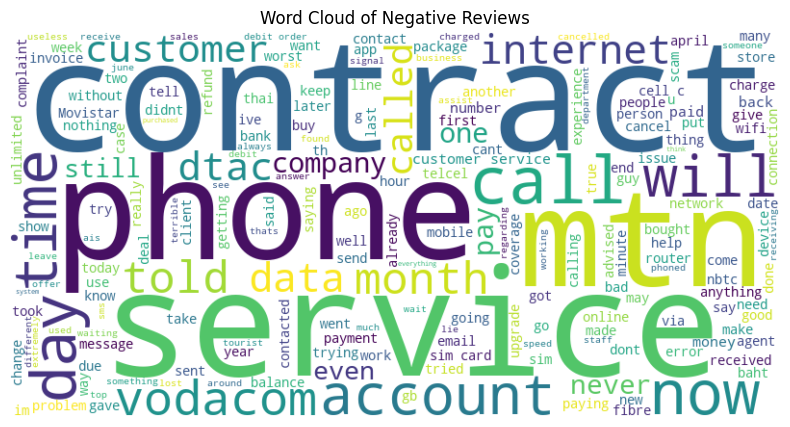

In [24]:
text = " ".join(df[df["sentiment_label"] == "negative"]["translated_review"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Reviews")
plt.show()

In [25]:
# # Summary stats
# summary = df.groupby("sentiment_label").agg(
#     count=("sentiment", "count"),
#     avg_score=("sentiment", "mean")
# ).reset_index()

# print(summary)

In [30]:
country_summary = df.groupby("country").agg(
    review_count=("review", "count"),
    avg_sentiment=("sentiment", "mean"),
    positive_pct=("sentiment_label", lambda x: (x == "positive").mean() * 100),
    negative_pct=("sentiment_label", lambda x: (x == "negative").mean() * 100),
    neutral_pct=("sentiment_label", lambda x: (x == "neutral").mean() * 100)
).reset_index()

country_summary

,country,review_count,avg_sentiment,positive_pct,negative_pct,neutral_pct
0,Mexico,97,-0.487523,10.309278,80.412371,9.278351
1,South Africa,275,-0.168176,34.909091,57.818182,7.272727
2,Thailand,91,-0.341027,17.582418,68.131868,14.285714


Mexico stands out with the lowest average sentiment and highest percentage of negative reviews — indicating widespread dissatisfaction, especially with providers like Movistar (based on what you scraped).

South Africa shows relatively milder negativity and a far higher share of positive reviews, suggesting mixed—but potentially redeemable—consumer experiences.

Thailand sits in the middle with sentiment skewed more negatively than South Africa but less intense than Mexico. Its neutral review share is highest, hinting at ambiguous or transactional feedback.